# Image set recognition with MSM

In the example code of this tutorial, we assume for simplicity that the following symbols are already imported.

In [1]:
from sklearn.datasets import fetch_openml
import sys, os, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
sys.path.insert(0, os.pardir)
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from cvt.models import MutualSubspaceMethod
from sklearn.svm import SVC

In this example we will start with principal component analysis (PCA) and work our way to classification with the subspace method (SM).

We will conduct the procedure in the following steps.

- Prepare a dataset
- Peform Classification using SVC
- Peform Classification using MSM

## 1. Prepare the dataset

The data that will be used in this example is the UMIST face dataset (A.K.A Sheffield face dataset). We use a cropped version that can be easily downloaded using `sklearn.datasets.fetch_openml`. [The extended Yale face database B](http://vision.ucsd.edu/~iskwak/ExtYaleDatabase/ExtYaleB.html) is also a good dataset for image set recognition, but here we use UMIST for the sake of simplicity.

**Details on the UMIST face dataset**

- Consists of 564(575?) images of 20 people. 
- Each covering a range of poses from profile to frontal views. 
- Subjects cover a range of race/sex/appearance. 
- Each image is of size 220x220 (112x92?)

In [7]:
# Download the data
X, y = fetch_openml('UMIST_Faces_Cropped', version=1, return_X_y=True)

print('Data shape: X', X.shape, 'y', y.shape)

print('Number of unique labels:', len(np.unique(y)))

print("Number of images for each label")

for i in range(20):
    image_count = len(X[np.where(y==str(i))])
    print(f'\tLabel: {i}, Num: {image_count}')

Data shape: X (575, 10304) y (575,)
Number of unique labels: 20
Number of images for each label
	Label: 0, Num: 38
	Label: 1, Num: 35
	Label: 2, Num: 26
	Label: 3, Num: 24
	Label: 4, Num: 26
	Label: 5, Num: 23
	Label: 6, Num: 19
	Label: 7, Num: 22
	Label: 8, Num: 20
	Label: 9, Num: 32
	Label: 10, Num: 34
	Label: 11, Num: 34
	Label: 12, Num: 26
	Label: 13, Num: 30
	Label: 14, Num: 19
	Label: 15, Num: 26
	Label: 16, Num: 26
	Label: 17, Num: 33
	Label: 18, Num: 48
	Label: 19, Num: 34


### 1.1 Visualize the dataset

The data is already flatten so if to visualize the image we must reshape it.

Below I have plotted 10 images for each of the 5 classes.

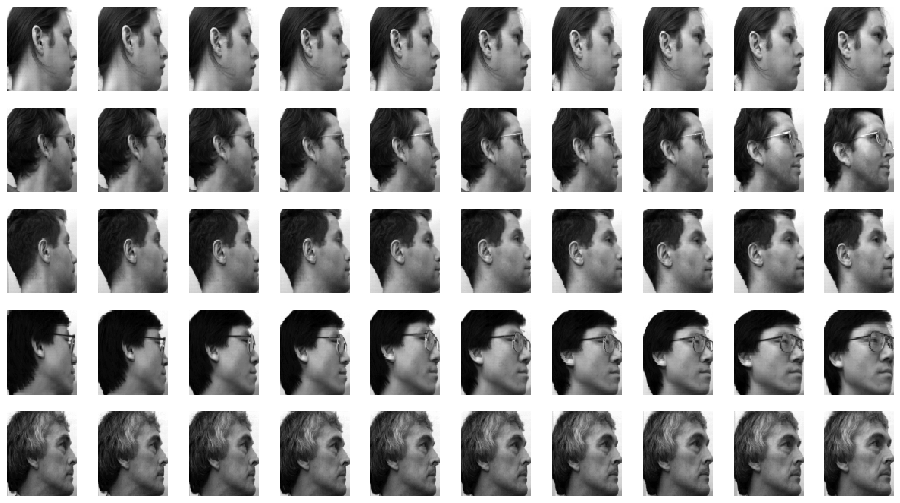

In [3]:
# Print 5 images for 10 class

nrows, ncols = 5, 10
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(16,9))

for i in range(0, nrows, 1):
    X_ = X[y==str(i)]
    
    for j in range(ncols):
        axs[i,j].imshow(X_[j].reshape(112, 92), cmap=plt.get_cmap('gray'))
        axs[i,j].axis('off')
        
plt.show()

### 1.2 Problem forumlation

We formulate the following classification problem.

Given a set of N=10 randomly selected images for each person (C=20) as training data, can we classify an unseen imageset of abitary size?

![](../docs/_static/examples/Image_set_recognition_with_MSM/face_sep.png)

### 1.3 Data separation

As seen in the image above, we will use 10 randomly selected images per person as training data. As for test data we will split the remaing data into smaller image sets (1~5 images per person) to make the classification more difficult.

In [86]:
X_train, y_train = [], []
X_test, y_test = [], []

n_classes = 20

for i in range(n_classes):
    X_ = X[y==str(i)]
    
    # Split train and test data
    train, test = train_test_split(X_, train_size=10, test_size=len(X_)-10, random_state=0, shuffle=True)
    
    X_train.append(train)
    y_train.append(i)
    
    # Split test data into chunks
    n_chunks = len(test) // 3
    split_points = np.random.choice(len(test)-1, n_chunks-1, replace=False) + 1
    split_points.sort()
    test_chunks = np.split(test, split_points)
    
    X_test.append(test_chunks)
    y_test.append([i] * n_chunks)

    # print to see if everything is okay
    print(f'Class {i}, train size: {len(train)}, test sizes: {list(map(len, test_chunks))}')

Class 0, train size: 10, test sizes: [6, 4, 2, 3, 7, 2, 1, 2, 1]
Class 1, train size: 10, test sizes: [2, 3, 2, 3, 7, 1, 6, 1]
Class 2, train size: 10, test sizes: [1, 3, 7, 2, 3]
Class 3, train size: 10, test sizes: [2, 3, 1, 8]
Class 4, train size: 10, test sizes: [1, 1, 10, 1, 3]
Class 5, train size: 10, test sizes: [3, 2, 5, 3]
Class 6, train size: 10, test sizes: [2, 4, 3]
Class 7, train size: 10, test sizes: [1, 3, 6, 2]
Class 8, train size: 10, test sizes: [4, 2, 4]
Class 9, train size: 10, test sizes: [2, 3, 1, 9, 2, 1, 4]
Class 10, train size: 10, test sizes: [4, 2, 1, 1, 4, 5, 6, 1]
Class 11, train size: 10, test sizes: [3, 3, 1, 1, 3, 5, 7, 1]
Class 12, train size: 10, test sizes: [2, 3, 5, 2, 4]
Class 13, train size: 10, test sizes: [1, 6, 6, 5, 1, 1]
Class 14, train size: 10, test sizes: [2, 2, 5]
Class 15, train size: 10, test sizes: [1, 2, 4, 2, 7]
Class 16, train size: 10, test sizes: [5, 4, 1, 2, 4]
Class 17, train size: 10, test sizes: [1, 1, 3, 2, 11, 4, 1]
Class 18,

## 2. Classification with MSM

In [90]:
msmc = MutualSubspaceMethod(n_subdims=5, faster_mode=True)

# Fit the data
msmc.fit(X_train, y_train)

# Predict the classes
y_pred = msmc.predict(X_test)

# Caluclate the accuracy
accuracy_score(y_test, y_pred)

AttributeError: 'list' object has no attribute 'T'

## 3. Classification with MSM

In [118]:
msmc = MutualSubspaceMethod(n_subdims=1)

# Fit the data
msmc.fit(X_train, y_train)
# Caluclate the accuracy
msmc.score(X_test, y_test)

1.0